# 1、Remove background

In [14]:
import os
from scipy.signal import find_peaks
import cv2
import numpy as np
from scipy.signal import medfilt, savgol_filter  # You can skip using this; kept as a backup
from matplotlib.patches import Rectangle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Literal
from typing import Sequence, List
from collections import Counter


def remove_background_and_binarize(
    input_path: str,
    output_path: str,
    manual_thresh: int = 180,
    blur_kernel: tuple[int, int] = (5, 5),
    lead_name_regions: list[tuple[int, int, int, int]] | None = None,
    clean_kernel: tuple[int, int] | None = (3, 3)
) -> None:
    """
    Remove background from ECG image, binarize it, and optionally remove isolated small dots.

    Args:
        input_path:      Path to the input image
        output_path:     Path to save the binarized result
        manual_thresh:   Grayscale threshold; values below this are considered signal (default 180)
        blur_kernel:     Gaussian blur kernel size (default (5, 5))
        lead_name_regions:
                         Optional list of rectangular regions [(x1, y1, x2, y2), ...],
                         filled with white on the binary map to mask lead text.
        clean_kernel:    If not None, use this kernel size for morphological opening denoising
                         (e.g., (3,3) will clear isolated dots smaller than this kernel).
    """
    # 1. Read image & convert to grayscale
    image = cv2.imread(input_path)
    if image is None:
        raise FileNotFoundError(f"Cannot read image: {input_path}")
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # 2. Optional Gaussian blur
    blurred = cv2.GaussianBlur(gray, blur_kernel, 0)

    # 3. Extract "black" foreground mask
    _, mask = cv2.threshold(
        blurred,
        manual_thresh,
        255,
        cv2.THRESH_BINARY_INV
    )

    # 4. Replace background area with white background
    background = np.full_like(image, 255)
    result = np.where(mask[:, :, None] == 255, image, background)

    # 5. Convert to grayscale and binarize
    result_gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
    _, final_binary = cv2.threshold(
        result_gray,
        127,
        255,
        cv2.THRESH_BINARY
    )

    # 6. Mask lead name regions
    if lead_name_regions:
        for (x1, y1, x2, y2) in lead_name_regions:
            cv2.rectangle(final_binary, (x1, y1), (x2, y2), 255, -1)

    # 7.1 Morphological opening: remove isolated small dots
    # Made some adjustments: using a kernel of (2,2) to remove isolated dots
    # might cause inflection points to become unclear.
    # if clean_kernel is not None:
    #     kernel = cv2.getStructuringElement(cv2.MORPH_RECT, clean_kernel)
    #     final_binary = cv2.morphologyEx(final_binary, cv2.MORPH_OPEN, kernel)

    # 7.2 Remove single pixel noise
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(final_binary, connectivity=8)
    # stats[i, cv2.CC_STAT_AREA] is the pixel area of the i-th connected component
    for i in range(1, num_labels):  # 0 is background
        if stats[i, cv2.CC_STAT_AREA] == 1:
            final_binary[labels == i] = 0  # Or 255, depending on your foreground/background definition

    # 8. Save result
    cv2.imwrite(output_path, final_binary)
    print(f"✅ Processing complete. Binary image saved to: {output_path}")

lead_name_regions = [
(105, 490,130, 520),
(1086, 490,1130, 520),

(105, 678,130, 710),
(1086, 678,1130, 710),

(105, 866,130, 898),
(1086, 866,1130, 898),

(105, 1063,150, 1097),
(1086, 1063,1130, 1097),

(105, 1253,150, 1283),
(1086, 1253,1130, 1283),

(105, 1443,150, 1473),
(1086, 1443,1130, 1473)

]

remove_background_and_binarize(
    input_path="./6x2.png",
    output_path="./6x2_remove.png",
    manual_thresh=180,
    blur_kernel=(3,3),
    lead_name_regions=lead_name_regions,
    clean_kernel=None
)

✅ Processing complete. Binary image saved to: ./6x2_remove.png


# 2、Manually locate boundaries and remove lead names

heigth = 1700,width = 2200


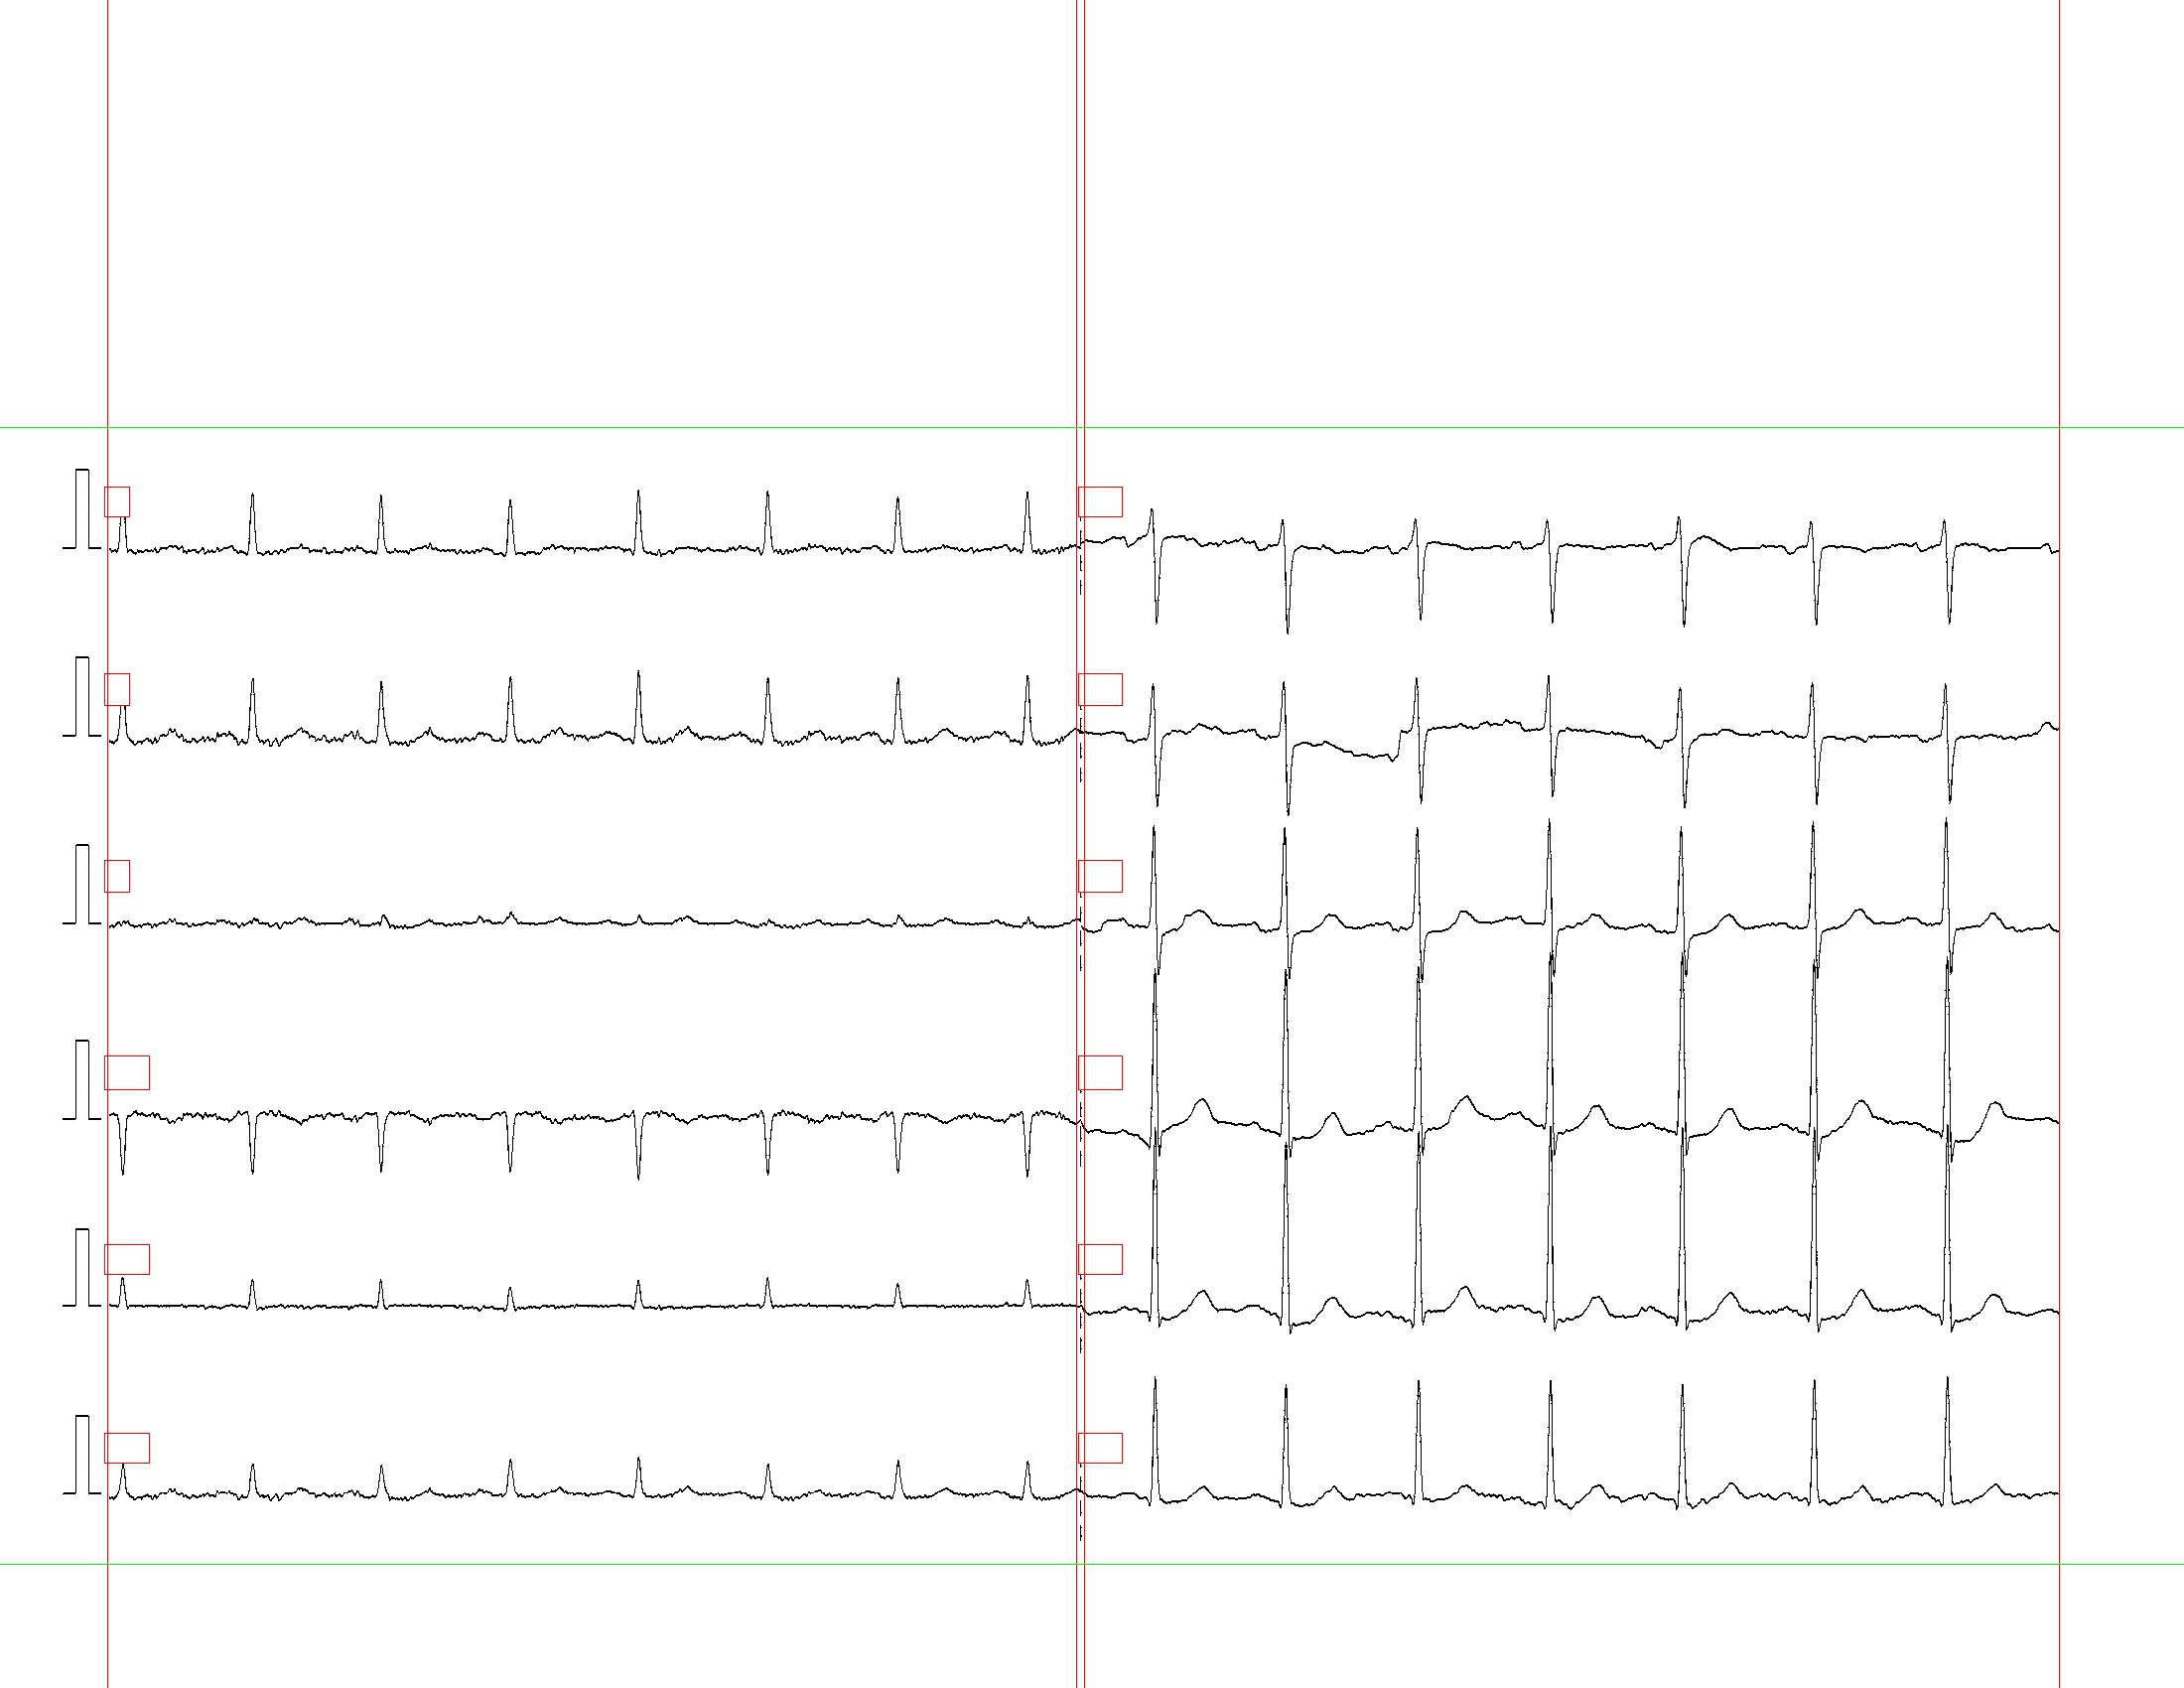

True

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image

img = cv2.imread(r'./6x2_remove.png')


height, width, _ = img.shape
print(f'heigth = {height},width = {width}')

cv2.line(img, (108, 0), (108, height), (0, 0, 255), 1) 
cv2.line(img, (1084, 0), (1084, height), (0, 0, 255), 1)  
cv2.line(img, (1092, 0), (1092, height), (0, 0, 255), 1)  

cv2.line(img, (2074, 0), (2074, height), (0, 0, 255), 1)


cv2.line(img, (0, 430), (width, 430), (0, 255, 0), 1)  
cv2.line(img, (0, 1575), (width, 1575), (0, 255, 0), 1)  


cv2.rectangle(img, (105, 490), (130, 520), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 490), (1130, 520), (0, 0, 255), 1)

cv2.rectangle(img, (105, 678), (130, 710), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 678), (1130, 710), (0, 0, 255), 1)

cv2.rectangle(img, (105, 866), (130, 898), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 866), (1130, 898), (0, 0, 255), 1)

cv2.rectangle(img, (105, 1063), (150, 1097), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 1063), (1130, 1097), (0, 0, 255), 1)

cv2.rectangle(img, (105, 1253), (150, 1283), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 1253), (1130, 1283), (0, 0, 255), 1)

cv2.rectangle(img, (105, 1443), (150, 1473), (0, 0, 255), 1)
cv2.rectangle(img, (1086, 1443), (1130, 1473), (0, 0, 255), 1)

_, buffer = cv2.imencode('.jpg', img)
display(Image(data=buffer.tobytes()))

cv2.imwrite(r'./6x2_add_border.png', img)

# 3、The lead position is located by pixel values.


Peak position indices: [ 124  316  500  693  884 1077]
Peak values: [149 114 195 128 226 123]
valley index 172, min value 0
valley index 362, min value 0
valley index 548, min value 0
valley index 756, min value 0
valley index 932, min value 0
Valley positions and values: [(np.int64(172), np.uint8(0)), (np.int64(362), np.uint8(0)), (np.int64(548), np.uint8(0)), (np.int64(756), np.uint8(0)), (np.int64(932), np.uint8(0))]


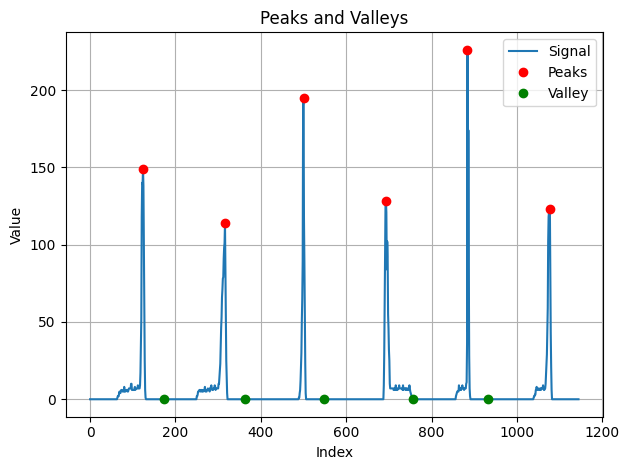

Peak position indices: [ 120  311  500  706  889 1078]
Peak values: [234 191 176 143 188 212]
valley index 209, min value 0
valley index 392, min value 0
valley index 571, min value 14
valley index 752, min value 14
valley index 936, min value 0
Valley positions and values: [(np.int64(209), np.uint8(0)), (np.int64(392), np.uint8(0)), (np.int64(571), np.uint8(14)), (np.int64(752), np.uint8(14)), (np.int64(936), np.uint8(0))]


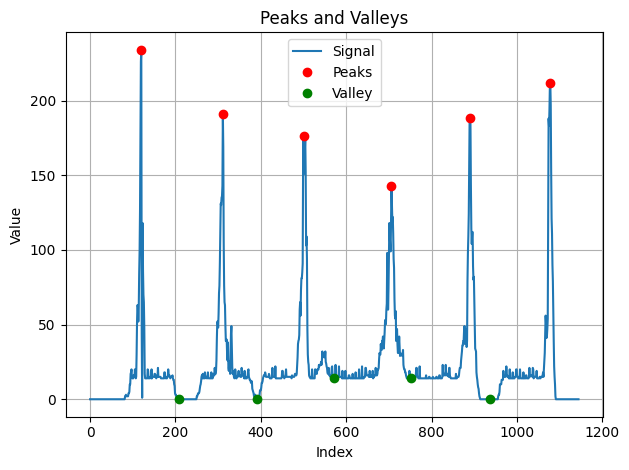

In [16]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

remove_path = r'./6x2_remove.png'
output_dir = r'./lead_px/'

# --- Read image and convert to grayscale ---
image = cv2.imread(remove_path)
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# --- Set column coordinates & vertical boundaries ---
columns = [(108, 1084), (1092, 2074)] # Only 2 columns, adjusted slightly
y_min, y_max = 430, 1575
proj_width = 300  # Width of the projection histogram on the right

projection_list = list() # Save pixel sum of each column
projection_norm_list = list() # Save pixel sum of each column, normalized

# find peak
from scipy.signal import find_peaks
def find_peak_index(data, save_path):

    # Example data: 1D signal
    data = np.array(data)
    # Detect peaks
    peaks, _ = find_peaks(data, height=50, distance=50, prominence=1)
    print("Peak position indices:", peaks)
    print("Peak values:", data[peaks])

    # Visualization
    plt.figure(figsize=(8, 4))
    plt.plot(data, label='Signal')
    plt.plot(peaks, data[peaks], "ro", label='Peaks')  # Mark peaks with red dots
    plt.title("Detected Peaks in 1D Data")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(save_path)
    plt.close()

    return peaks

# --- Main processing flow ---
valley_index_list = list()
for i, (x1, x2) in enumerate(columns):
    # 1. Crop original column region image
    col_img = image[y_min:y_max, x1:x2]
    col_gray = gray[y_min:y_max, x1:x2]

    # 2. Calculate pixel sum (invert black and white)
    signal = 255 - col_gray
    projection = np.sum(signal, axis=1) # Pixel sum (1145,)
    projection_norm = (projection / np.max(projection) * proj_width).astype(np.uint8)

    projection_list.append(projection)
    projection_norm_list.append(projection_norm)


    # =======================================================================
    # 3. Visualize histogram
    vis_height = len(projection_norm)
    vis_img = np.ones((vis_height, proj_width, 3), dtype=np.uint8) * 255
    for y, val in enumerate(projection_norm):
        vis_img[y, :val] = [0, 0, 0]  # Black bar

    # Concatenate: Original image on the left, histogram on the right
    combined = np.hstack((col_img, vis_img))

    # Save image
    out_path = os.path.join(output_dir, f"column_{i}_combined.png")
    cv2.imwrite(out_path, combined)
    # print(f"Column {i} combined image saved to: {out_path}")
    # =======================================================================

    # 4. Save peak image
    out_path_peak = os.path.join(output_dir, f"column_{i}_peak.png")
    peak_return = find_peak_index(projection_norm, out_path_peak) # return peak
    valleys = []

    # 5.1. Find minimum value between peak-peak
    # Detect minimum value (valley) between adjacent peaks
    
    # for i in range(len(peak_retrun) - 1):
    #     start = peak_retrun[i]
    #     end = peak_retrun[i + 1]
    #     valley_index = start + np.argmin(projection_norm[start:end + 1])  # +1 to include the right end

    #     print(f" valley index {valley_index },min value {projection_norm[valley_index]}")
    #     valleys.append((valley_index, projection_norm[valley_index]))

    # valley_index_list.append(valleys)
    # # Output valley information
    # print("Valley positions and values:", valleys)



    # 5.2. Find minimum value between peak-peak
    for i in range(len(peak_return) - 1):
        start = peak_return[i]
        end   = peak_return[i + 1]
        dist  = end - start

        # 1. Midpoint
        mid = start + dist // 2

        # 2. Sub-interval half-width: 25% of the entire peak distance
        half_win = int(dist * 0.25)

        # Limit interval to avoid out of bounds
        win_start = max(start, mid - half_win)
        win_end   = min(end,   mid + half_win)

        # 3. Find minimum in the sub-interval
        segment = projection_norm[win_start : win_end + 1]
        if len(segment) > 0:
            offset = np.argmin(segment)
            valley_idx = win_start + offset
        else:
            # If sub-interval length is 0, fallback to full interval search
            valley_idx = start + np.argmin(projection_norm[start : end + 1])

        valley_val = projection_norm[valley_idx]
        print(f"valley index {valley_idx}, min value {valley_val}")

        valleys.append((valley_idx, valley_val))
    
    valley_index_list.append(valleys)
    # Output valley information
    print("Valley positions and values:", valleys)
    # Visualize valleys
    out_path_peaktopeak_botton = os.path.join(output_dir, f"column_{i}_peaks_botton.png")
    plt.plot(projection_norm, label='Signal')
    plt.plot(peak_return, projection_norm[peak_return], "ro", label='Peaks')
    for idx, val in valleys:
        plt.plot(idx, val, "go", label='Valley' if idx == valleys[0][0] else "")  # Add legend only once
    plt.title("Peaks and Valleys")
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    # plt.savefig(out_path_peaktopeak_botton)
    plt.close()

# 4、Boundary positioning visualization

In [17]:
flattened_list = [num for sublist in valley_index_list for point in sublist for num in point]
a = np.array(flattened_list)
print(a.shape)
# [(105, 1086), (1090, 2074)]
# 430, 1575

col_1 = [int(a[0]), int(a[2]), int(a[4]), int(a[6]), int(a[8])]
col_2 = [int(a[10]), int(a[12]), int(a[14]), int(a[16]), int(a[18])]

regions = [
    (105 , 430,1084,430+col_1[0]),
    (105 , 430+col_1[0],1084,430+col_1[1]),
    (105 , 430+col_1[1],1084,430+col_1[2]),
    (105 , 430+col_1[2],1084,430+col_1[3]),
    (105 , 430+col_1[3],1084,430+col_1[4]),
    (105 , 430+col_1[4],1084,1575),

    (1092 , 430,2074,430+col_2[0]),
    (1092 , 430+col_2[0],2074,430+col_2[1]),
    (1092 , 430+col_2[1],2074,430+col_2[2]),
    (1092 , 430+col_2[2],2074,430+col_2[3]),
    (1092 , 430+col_2[3],2074,430+col_2[4]),
    (1092 , 430+col_2[4],2074,1575)
]


# 在图像上绘制矩形框
for (x1, y1, x2, y2) in regions:
    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

# 保存或显示结果
cv2.imwrite(os.path.join(output_dir, "with_regions_new.png"), image)

(20,)


True

# 5、Digitalization

[(1092, 822, 2074, 1001), (1092, 1001, 2074, 1182), (1092, 1182, 2074, 1366)]


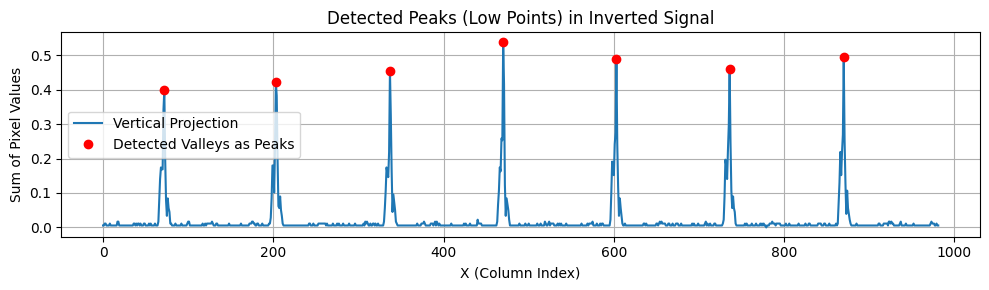

Original peaks: [ 72 203 337 470 603 736 870]
Refined peaks: [ 69 201 334 467 600 733 867]


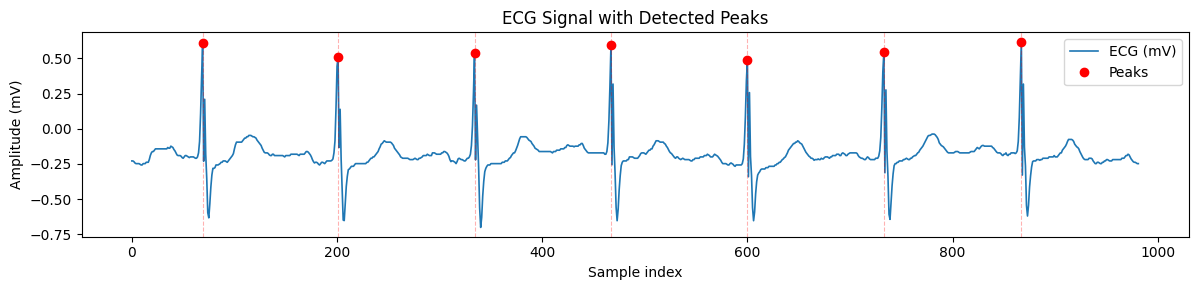

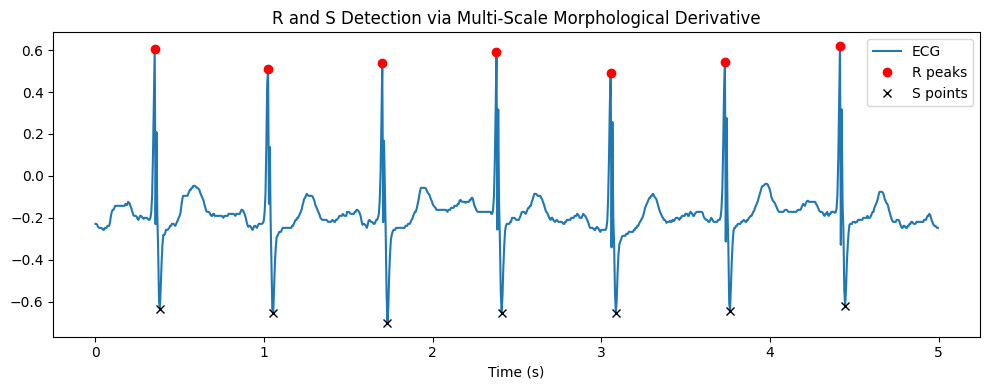

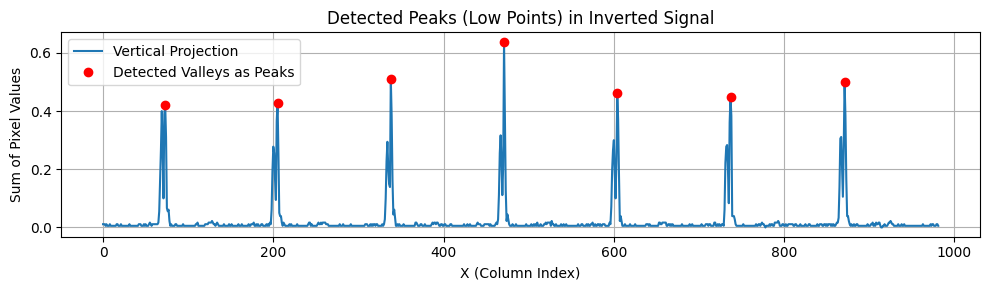

Original peaks: [ 73 205 338 471 604 737 871]
Refined peaks: [ 69 201 334 467 600 733 867]


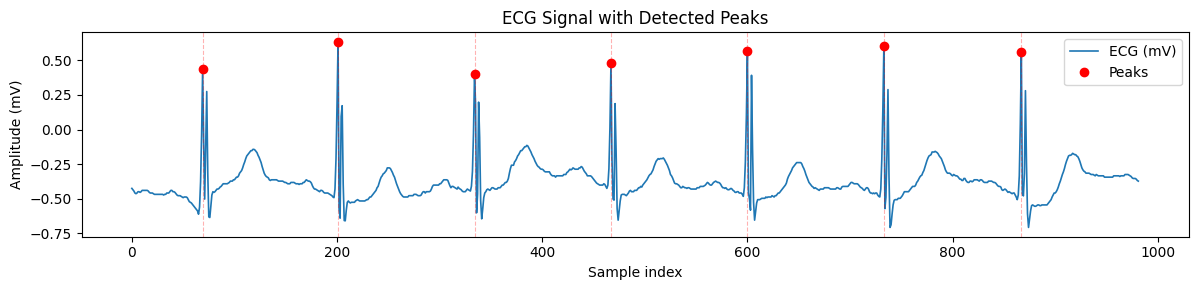

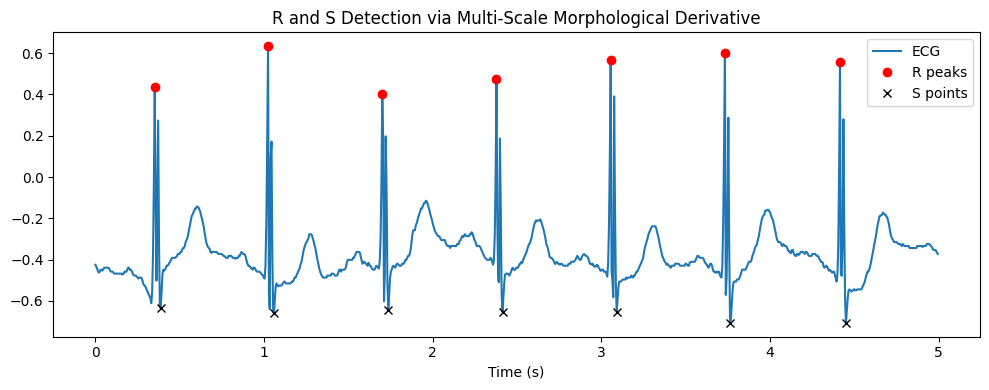

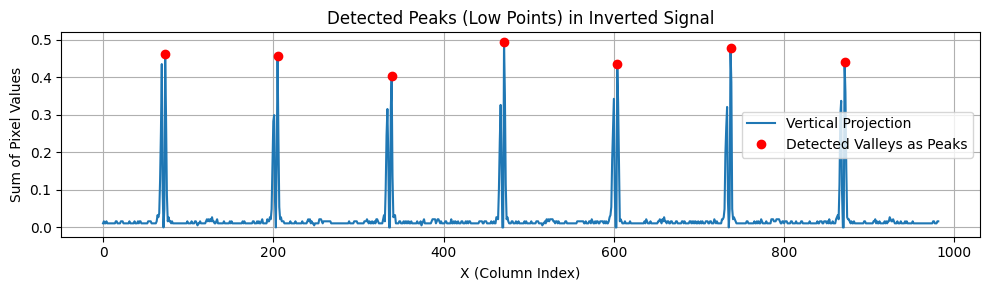

Original peaks: [ 73 205 339 471 604 737 871]
Refined peaks: [ 72 202 335 468 601 736 868]


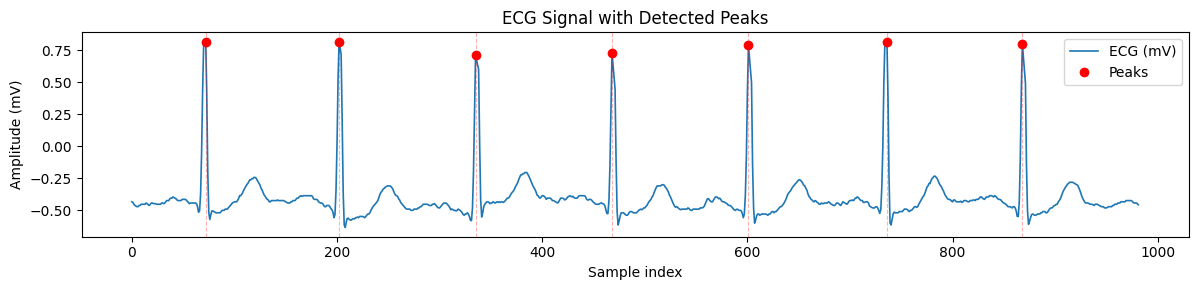

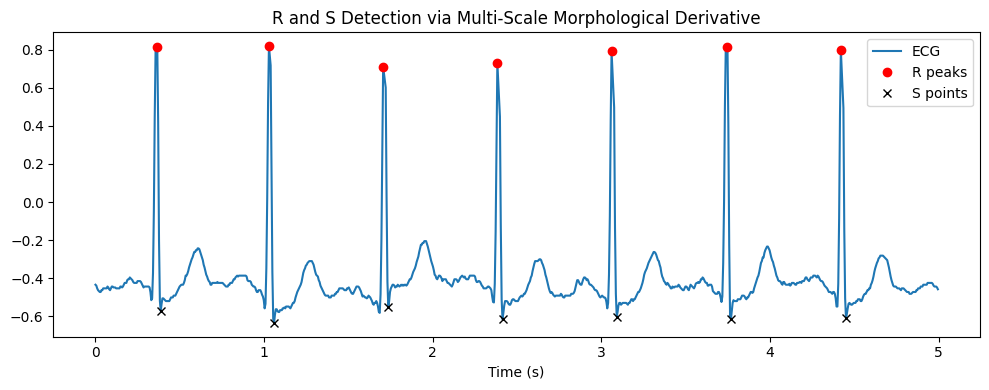

(6, 979)
(6, 982)
(12, 1961)


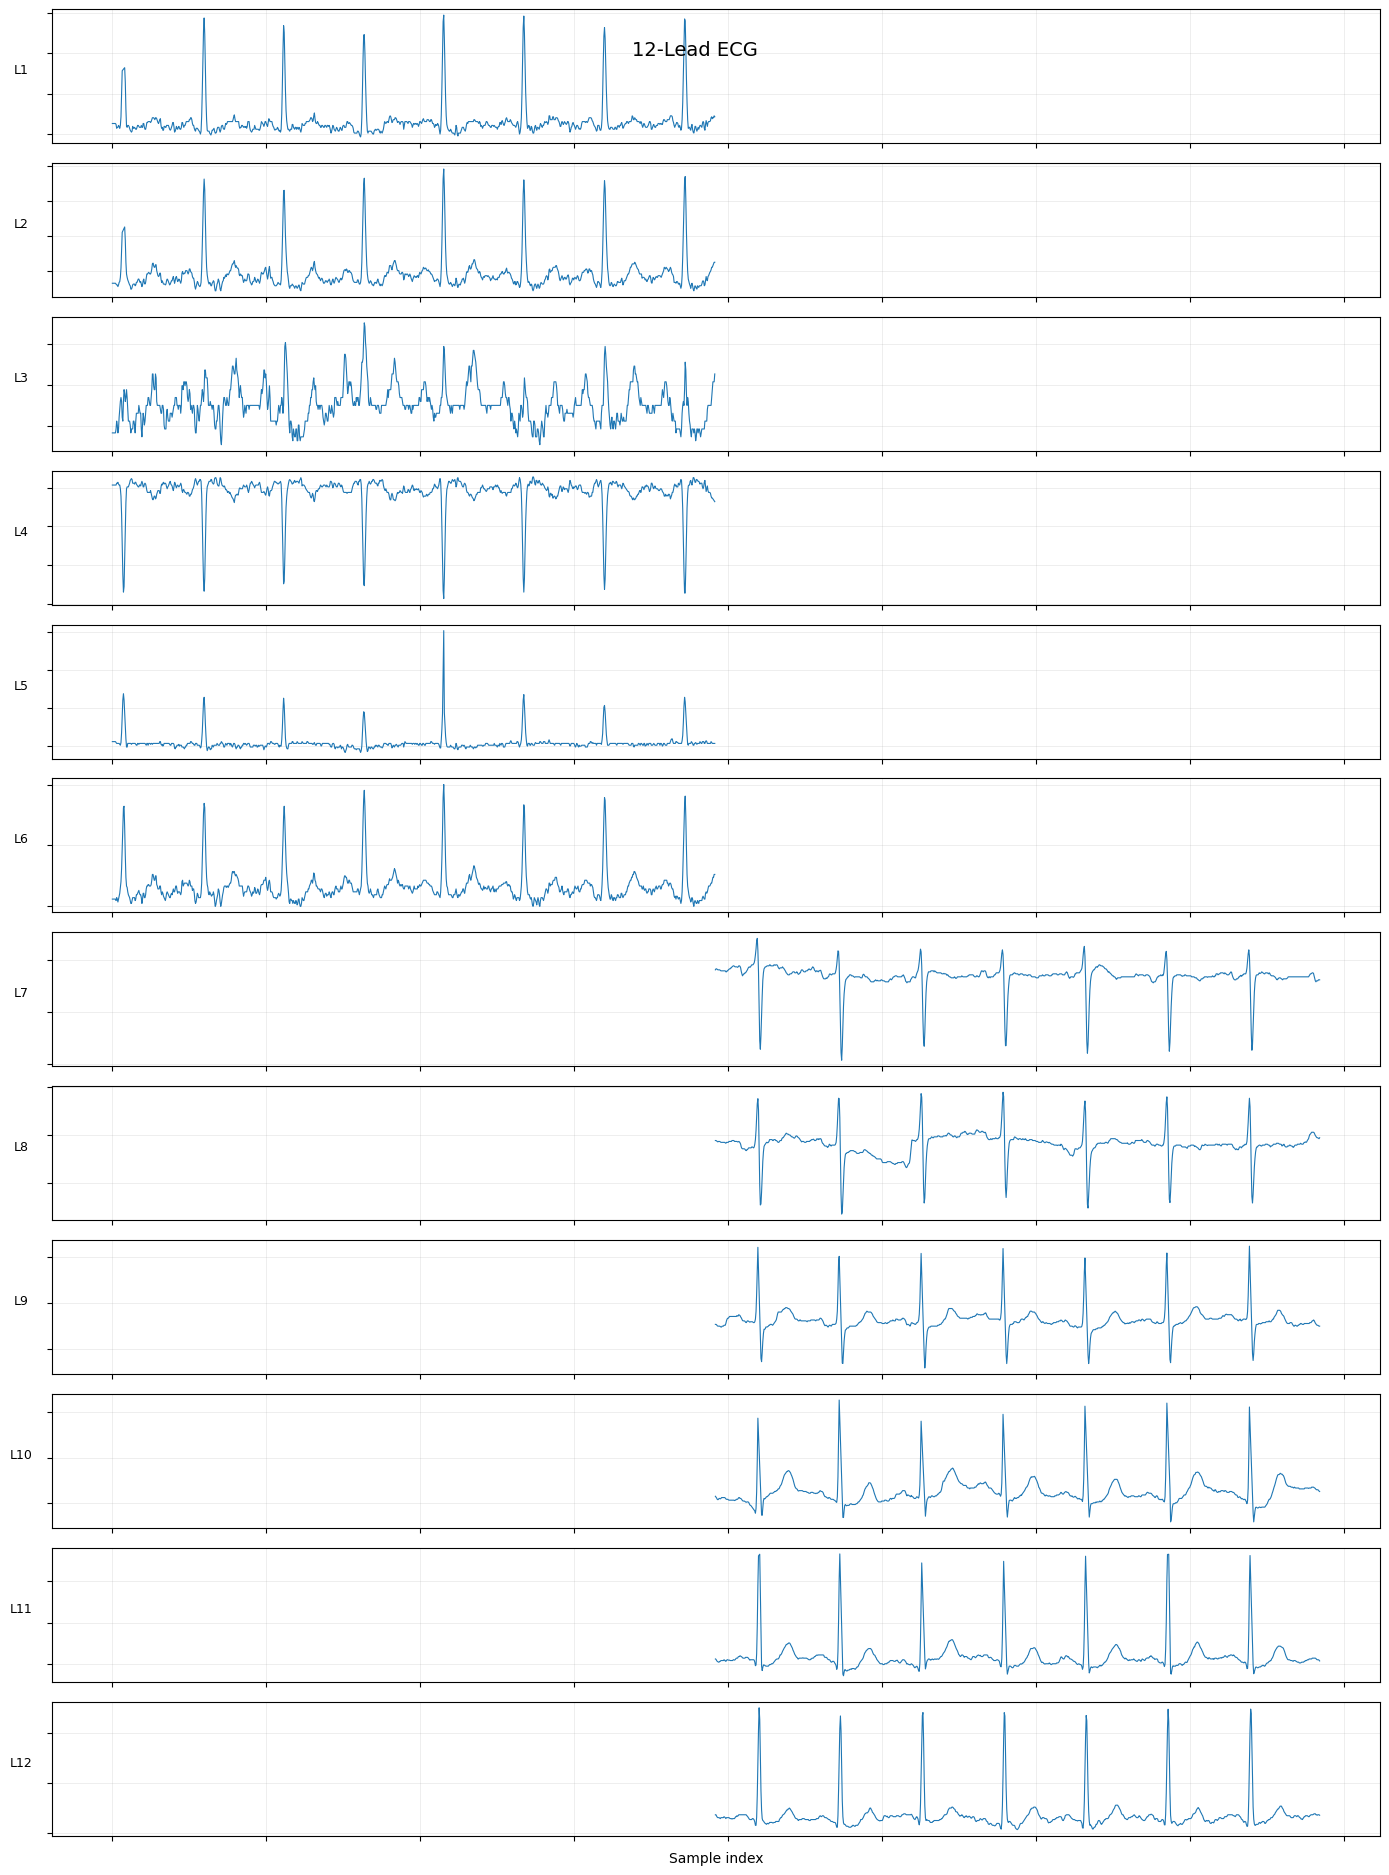

12
Signal drawing completed!


In [18]:
import cv2
import numpy as np
from scipy.signal import medfilt, savgol_filter  # You can skip using this; kept here as a backup
from matplotlib.patches import Rectangle
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Sequence, List
from typing import Literal

image_path_remove = r'./6x2_remove.png'
gray = cv2.imread(image_path_remove, cv2.IMREAD_GRAYSCALE)
img_color = cv2.imread(image_path_remove)

# Estimate px/mm (manually)
px_per_mm = 2200 / 210  # Or manually adjust until waveform height fits the 10mm/mV standard
mv_per_pixel = 1 / (10 * px_per_mm)
time_per_pixel = 1 / (25 * px_per_mm)

# These lists (col_1, col_2, valley_index_list) seem to come from previous context/code not fully shown here.
# Assuming they exist in the running environment. 
# If this script is standalone, these variables need to be defined before use.
regions = [
    (105 , 430,1084,430+col_1[0]),
    (105 , 430+col_1[0],1084,430+col_1[1]),
    (105 , 430+col_1[1],1084,430+col_1[2]),
    (105 , 430+col_1[2],1084,430+col_1[3]),
    (105 , 430+col_1[3],1084,430+col_1[4]),
    (105 , 430+col_1[4],1084,1575),

    (1092 , 430,2074,430+col_2[0]),
    (1092 , 430+col_2[0],2074,430+col_2[1]),
    (1092 , 430+col_2[1],2074,430+col_2[2]),
    (1092 , 430+col_2[2],2074,430+col_2[3]),
    (1092 , 430+col_2[3],2074,430+col_2[4]),
    (1092 , 430+col_2[4],2074,1575)
]

adhesion_regions = list() # Record borders where adhesion occurs
for group_idx, group in enumerate(valley_index_list):
    # print(f"Group {group_idx + 1} valleys:")
    for valley_idx, (idx, value) in enumerate(group):
        # print(f"  → Group {group_idx}, Valley {valley_idx}: Pos = {idx}, Value = {value}")
        # group_idx is the group where adhesion occurs, valley is the adhesion border
        if value > 0:
            adhesion_regions.append(regions[6*group_idx+valley_idx])
            adhesion_regions.append(regions[6*group_idx+valley_idx+1])

adhesion_regions = list(dict.fromkeys(adhesion_regions)) # Remove duplicates

print(adhesion_regions)



def Pixel_to_signal(roi, mv_per_pixel=1 / (10 * px_per_mm)):

    h, w = roi.shape
    signal = []
    for col in range(w):
        col_data = roi[:, col]
        black_indices = np.where(col_data < 100)[0]  # Black line threshold adjustable
        if len(black_indices) > 0:
            y = np.mean(black_indices)
        else:
            y = np.nan
        signal.append(y)

    # Interpolate to fill missing values
    signal = np.array(signal)
    nan_mask = np.isnan(signal)
    if np.any(~nan_mask):
        signal[nan_mask] = np.interp(np.flatnonzero(nan_mask), np.flatnonzero(~nan_mask), signal[~nan_mask])
    else:
        signal[:] = h / 2

    # Vertical center baseline
    center = h / 2
    ecg_mv = -(signal - center) * mv_per_pixel
    return ecg_mv

# Pad signal data, used for plotting to CSV file, format adjustment
"""
General idea: Left-align the first 6 leads, then align the last 6 leads. 
The longest length is the maximum of the two groups, fill if insufficient.
Later found that the length is actually fixed.
"""
def pad_arrays_to_length(arrays: Sequence[np.ndarray],
                         target_len: int,
                         axis: int = -1,
                         pad_value: float | int = 0,
                         truncate: bool = True) -> List[np.ndarray]:
    """
    Pad a batch of ndarrays with 0 (or other value) along the specified axis to target_len.

    Parameters
    ----------
    arrays : Sequence[np.ndarray]
        List of arrays to be padded. E.g., [array([..]), array([..]), ...] or
        [array(12,5000), array(12,4800), ...] etc.
    target_len : int
        Target length (along the axis direction).
    axis : int, optional
        Axis to perform padding; default -1 is fine for 1-D data.
    pad_value : float | int, optional
        Constant used for padding. Default 0.
    truncate : bool, optional
        If a sequence length > target_len:
        - True  -> Truncate to target_len
        - False -> Keep original length (return value lengths will be inconsistent)

    Returns
    -------
    List[np.ndarray]
        List of padded (or truncated) arrays. Dimensions are same as original, length unified to target_len.
    """
    padded = []
    for a in arrays:
        # Get actual length of the padding axis
        cur_len = a.shape[axis]

        # ------ Case 1: Need truncation ------
        if truncate and cur_len > target_len:
            slicer = [slice(None)] * a.ndim
            slicer[axis] = slice(0, target_len)
            a = a[tuple(slicer)]
            cur_len = target_len

        # ------ Case 2: Need padding with 0 ------
        if cur_len < target_len:
            pad_width = [(0, 0)] * a.ndim
            pad_width[axis] = (0, target_len - cur_len)
            a = np.pad(a, pad_width,
                       mode="constant",
                       constant_values=pad_value)

        padded.append(a)

    return padded

def concat_12lead(group1: np.ndarray,
                  group2: np.ndarray,
                  pad_val: float | int | Literal["nan"] = 0) -> np.ndarray:
    """
    Parameters
    ----------
    group1 : ndarray, shape (6, len_1)
    group2 : ndarray, shape (6, len_2)
        Two groups of 6-lead ECG, column direction is time.
    pad_val : float | int | "nan", optional
        Value used for blank padding; passing "nan" will automatically convert to np.nan.

    Returns
    -------
    combined : ndarray, shape (12, len_1 + len_2)
        First 6 rows are group1, last 6 rows are group2 (starting from len_1).
    """
    if group1.shape[0] != 6 or group2.shape[0] != 6:
        raise ValueError("The first dimension of both data groups must be 6 (number of leads)")

    len_1 = group1.shape[1]
    len_2 = group2.shape[1]
    T     = len_1 + len_2                       # Total time length

    fill = np.nan if pad_val == "nan" else pad_val
    combined = np.full((12, T), fill, dtype=float)

    # Write first 6 leads
    combined[:6, :len_1] = group1

    # Write last 6 leads, starting from len_1
    combined[6:, len_1:len_1 + len_2] = group2

    return combined

# QRS detection
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

# These two were attempts, (discarded)
def morphological_gradient_1d(signal: np.ndarray, kernel_size: int) -> np.ndarray:
    """
    Perform morphological gradient (dilation - erosion) on 1D signal.
    Use OpenCV to treat the signal as a 1xN "image".
    """
    # Convert to float32 and reshape to 1xN "image"
    img = signal.astype(np.float32).reshape(1, -1)
    # 1D horizontal structuring element
    se = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_size, 1))
    dilated = cv2.dilate(img, se)
    eroded  = cv2.erode(img, se)
    grad = (dilated - eroded).flatten()
    return grad

def multi_scale_mmd(signal: np.ndarray, scales: list[int]) -> np.ndarray:
    """
    Calculate weighted sum (or simple sum) of multi-scale morphological derivatives.
    scales: List of structuring element half-widths, usually odd, e.g. [3,5,7,9]
    """
    grads = [morphological_gradient_1d(signal, k) for k in scales]
    # Simple sum, superposition of responses at different scales, suppressing noise
    return np.sum(grads, axis=0)

# Recover intermediate signal data using slope
def restore_segment_by_slope(signal: np.ndarray,
                             x_left: int,
                             x_right: int,
                             mask_val=np.nan):
    """
    Use the slope of the line connecting endpoints (x_left, x_right) to linearly recover the masked segment.

    Parameters
    ----------
    signal : np.ndarray
        1D ECG or other sequence, length N. The gap can be NaN or `mask_val`.
    x_left, x_right : int
        Indices of gap boundaries (must satisfy 0 <= x_left < x_right < len(signal)).
        signal[x_left] and signal[x_right] must be valid values (not NaN / not mask_val).
    mask_val : float or int, optional
        Special value to mark the gap. Default is NaN. If gap is already NaN, keep default.

    Returns
    -------
    np.ndarray
        New repaired array (same shape as original). Original array is not modified in-place.
    """
    # --- 0. Boundary and valid value check ---
    if not (0 <= x_left < x_right < signal.size):
        raise ValueError("x_left/x_right out of bounds or incorrect order")
    y_left, y_right = signal[x_left], signal[x_right]

    # If endpoints are NaN or mask_val, slope cannot be calculated
    def _invalid(v):   # Check invalid
        if np.isnan(mask_val):
            return np.isnan(v)
        return v == mask_val or np.isnan(v)

    if _invalid(y_left) or _invalid(y_right):
        raise ValueError("Left and right endpoints must be valid numbers")

    # --- 1. Calculate slope & generate interpolation --- (Selecting more points on left/right might improve slope)
    slope = (y_right - y_left) / (x_right - x_left)
    xs = np.arange(x_left + 1, x_right)      # Positions to fill
    ys = y_left + slope * (xs - x_left)      # Linear interpolation values

    # --- 2. Apply to new copy (do not modify original array) ---
    fixed = signal.copy()
    fixed[xs] = ys

    return fixed

def detect_R_peaks_mmd(
    ecg: np.ndarray,
    fs: float,
    scales: list[int] = [3, 5, 7, 9],
    mmd_thresh_factor: float = 0.5,
    min_distance_ms: int = 200
) -> np.ndarray:
    """
    Detect R peaks based on MMD signal.
    - ecg: Raw ECG signal
    - fs: Sampling rate (Hz)
    - scales: MMD multi-scale list
    - mmd_thresh_factor: Threshold factor, final threshold = mean(MMD) + factor*std(MMD)
    - min_distance_ms: Minimum interval between adjacent R peaks (ms)
    """
    mmd_sig = multi_scale_mmd(ecg, scales)
    # Adaptive threshold
    thresh = np.mean(mmd_sig) + mmd_thresh_factor * np.std(mmd_sig)
    # Peak detection
    distance = int(min_distance_ms * fs / 1000)
    peaks, props = find_peaks(mmd_sig, height=thresh, distance=distance)
    return peaks

# Find pixel value peaks; recognition is accurate but does not locate actual R peaks
def detect_peaks_via_projection(
    roi_ad: np.ndarray,
    height: float | None = None,
    distance: int = 100
) -> tuple[np.ndarray, np.ndarray]:
    """
    Detect peaks corresponding to "low points" in roi_ad using inverted pixel projection.

    Args:
      roi_ad   – Grayscale image sub-region, shape=(h_ad, w_ad)
      height   – Minimum height threshold for peak detection; if None, defaults to inv_proj.mean()
      distance – Minimum horizontal distance (pixels) between peaks to avoid duplicates

    Returns:
      peaks      – Array of peak indices in column direction (relative to roi_ad)
      inv_proj   – 1D array of inverted projection, useful for visualization or tuning
    """
    # 1. Sum pixels column-wise -> project
    project = np.sum(roi_ad, axis=0)         # shape (w_ad,)
    proj_norm  = project / (project.max() + 1e-7)
    # 2. Invert: max(project) - project
    inv_proj = np.max(proj_norm) - proj_norm     # Darker (blacker) columns have higher inv_proj values

    # 3. Adaptive height threshold
    if height is None:
        height = inv_proj.mean()

    # 4. Peak detection
    peaks, properties = find_peaks(
        inv_proj,
        height=height,
        distance=distance
    )

    # Plot pixel values and peak positions to visualize if this single lead has adhesion
    plt.figure(figsize=(10, 3)) # Plot for each border
    plt.plot(inv_proj, label='Vertical Projection')
    plt.plot(peaks, inv_proj[peaks], 'ro', label='Detected Valleys as Peaks')
    plt.title("Detected Peaks (Low Points) in Inverted Signal")
    plt.xlabel("X (Column Index)")
    plt.ylabel("Sum of Pixel Values")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    # plt.savefig(r"D:/code/tools/dig/6x2test_overlop/"+str(x1)+"_"+str(y1)+"_"+str(x2)+"_"+str(y2)+".png")
    plt.show()



    return peaks, inv_proj

# Relocate R peaks based on maximum signal value
def refine_peaks(
    ecg_mv: np.ndarray,
    peaks: list[int],
    search_radius: int = 5
) -> list[int]:
    """
    Refine peak positions by searching for the maximum signal value within ±search_radius
    around each initial peak peaks[i].

    Args:
      ecg_mv         – Digitized ECG signal (1D numpy array)
      peaks          – List of initially detected peak indices
      search_radius  – Search radius (number of sample points)

    Returns:
      new_peaks      – List of refined peak indices (deduplicated and sorted)
    """
    n = len(ecg_mv)
    refined = []
    for p in peaks:
        # Define search window
        start = max(0, p - search_radius)
        end   = min(n - 1, p + search_radius)
        # Find relative index of the max value in the window
        local_seg = ecg_mv[start:end+1]
        # np.argmax returns position of the first maximum
        offset = int(np.argmax(local_seg))
        new_p = start + offset
        refined.append(new_p)

    # Deduplicate and sort
    refined = np.array(sorted(set(refined)), dtype=int)
    return refined


def mask_baselines(
    roi_ad: np.ndarray,
    ecg_mv: np.ndarray,
    R_idxs,
    S_idxs,
    masked: np.ndarray | None = None
) -> tuple[np.ndarray, list[dict]]:
    """
    Locate and mask two baseline regions for each pair (R_peak, S_peak).

    Args:
      roi_ad   – Grayscale sub-image, shape=(h_ad, w_ad)
      ecg_mv   – Digitized ECG amplitude, len=w_ad
      R_idxs   – List or array of R peak indices
      S_idxs   – List or array of S wave indices (length must match R_idxs)
      masked   – Optional initial mask image (grayscale); if None, defaults to white background

    Returns:
      masked   – Image after masking
      coords   – List of coordinate dictionaries for each (R, S) pair
    """
    # Convert input to 1D integer numpy array
    R_arr = np.atleast_1d(R_idxs).astype(int).flatten()
    S_arr = np.atleast_1d(S_idxs).astype(int).flatten()
    assert len(R_arr) == len(S_arr), "R_idxs and S_idxs must have the same length"

    h_ad, w_ad = roi_ad.shape
    if masked is None:
        masked = np.full_like(roi_ad, 255)

    # Row index of the "darkest" pixel in each column
    row_idxs = np.argmin(roi_ad, axis=0).astype(int)
    # ECG first derivative
    d = np.diff(ecg_mv).astype(float)  # len = w_ad-1

    coords_list = []
    for R_idx, S_idx in zip(R_arr, S_arr):
        # 1. Around R peak: find first d>0 on left, first d<0 on right
        x1 = next((x for x in range(R_idx-1, -1, -1) if d[x] > 0), 0)
        x2 = next((x for x in range(R_idx, len(d))     if d[x] < 0), w_ad-1)
        # 2. Around S wave: find first d<0 on left, first d>0 on right
        x3 = next((x for x in range(S_idx-1, -1, -1) if d[x] < 0), 0)
        x4 = next((x for x in range(S_idx, len(d))     if d[x] > 0), w_ad-1)

        # Corresponding row indices
        y1, y2 = int(row_idxs[x1]), int(row_idxs[x2])
        y3, y4 = int(row_idxs[x3]), int(row_idxs[x4])

        # Baseline takes average of endpoint row indices
        baseline1 = (y1 + y2) // 2
        baseline2 = (y3 + y4) // 2

        # Masking: Above baseline1 (0..baseline1), columns x1..x2
        masked[0 : baseline1+1, x1 : x2+1] = 255
        # Masking: Below baseline2 (baseline2..h_ad-1), columns x3..x4
        masked[baseline2 : h_ad, x3 : x4+1] = 255

        coords_list.append({
            "x1": x1, "y1": y1,
            "x2": x2, "y2": y2,
            "baseline1": int(baseline1),
            "x3": x3, "y3": y3,
            "x4": x4, "y4": y4,
            "baseline2": int(baseline2),
        })

    return masked, coords_list
        # 1. Mask based on 2 baselines and 4 coordinates
        # # 2. Directly mask all parts in between
        # masked[0 : h_ad, x1 : x4+1] = 255

# baseline1 and baseline2 search starts around 1/4 and 3/4. The search process is similar.
def mask_baselines_v2(
    roi_ad: np.ndarray,
    ecg_mv: np.ndarray,
    R_idxs,
    S_idxs,
    masked: np.ndarray | None = None,
    search_frac: float = 0.1
) -> tuple[np.ndarray, list[dict]]:
    """
    For each pair (R_peak, S_peak), locate and mask two baseline regions:
      - baseline1: Within ±search_frac*h_ad around 1/4 ROI height,
        take the row closest to (y1+y2)/2
      - baseline2: Within ±search_frac*h_ad around 3/4 ROI height,
        take the row closest to (y3+y4)/2

    Args:
      roi_ad      – Grayscale sub-image, shape=(h_ad, w_ad)
      ecg_mv      – Digitized ECG amplitude, len=w_ad
      R_idxs      – List or array of R peak indices
      S_idxs      – List or array of S wave indices (length must match R_idxs)
      masked      – Optional initial mask image (grayscale); if None, defaults to white background
      search_frac – Search window half-height ratio (default 0.1, i.e., ±10%)

    Returns:
      masked     – Image after masking
      coords_list– List of coordinate dictionaries for each (R, S) pair
    """
    R_arr = np.atleast_1d(R_idxs).astype(int).flatten()
    S_arr = np.atleast_1d(S_idxs).astype(int).flatten()
    assert len(R_arr) == len(S_arr), "R_idxs and S_idxs must have the same length"

    h_ad, w_ad = roi_ad.shape
    if masked is None:
        masked = np.full_like(roi_ad, 255)

    # Row index of the "darkest" pixel in each column
    row_idxs = np.argmin(roi_ad, axis=0).astype(int)
    # ECG first derivative
    d = np.diff(ecg_mv).astype(float)

    coords_list = []
    # Calculate search window
    delta = int(h_ad * search_frac)
    low1, high1 = max(0, int(h_ad*0.25) - delta), min(h_ad-1, int(h_ad*0.25) + delta)
    low2, high2 = max(0, int(h_ad*0.75) - delta), min(h_ad-1, int(h_ad*0.75) + delta)

    for R_idx, S_idx in zip(R_arr, S_arr):
        # Find slope change points around R peak
        x1 = next((x for x in range(R_idx-1, -1, -1) if d[x] > 0), 0)
        x2 = next((x for x in range(R_idx, len(d))    if d[x] < 0), w_ad-1)
        # Find slope change points around S wave
        x3 = next((x for x in range(S_idx-1, -1, -1) if d[x] < 0), 0)
        x4 = next((x for x in range(S_idx, len(d))    if d[x] > 0), w_ad-1)

        # Corresponding row indices
        y1, y2 = row_idxs[x1], row_idxs[x2]
        y3, y4 = row_idxs[x3], row_idxs[x4]

        # Calculate average row
        avg1 = (int(y1) + int(y2)) / 2
        avg2 = (int(y3) + int(y4)) / 2

        # Select integer row closest to avg1 within window [low1, high1]
        candidates1 = np.arange(low1, high1+1)
        baseline1 = int(candidates1[np.abs(candidates1 - avg1).argmin()])
        # Similarly select baseline2
        candidates2 = np.arange(low2, high2+1)
        baseline2 = int(candidates2[np.abs(candidates2 - avg2).argmin()])

        # Masking: First region above baseline1 in [x1..x2]
        masked[0:baseline1+1, x1:x2+1] = 255
        # Masking: Second region below baseline2 in [x3..x4]
        masked[baseline2:h_ad, x3:x4+1] = 255
        

        coords_list.append({
            "x1": int(x1), "y1": int(y1),
            "x2": int(x2), "y2": int(y2),
            "baseline1": baseline1,
            "x3": int(x3), "y3": int(y3),
            "x4": int(x4), "y4": int(y4),
            "baseline2": baseline2,
        })

    return masked, coords_list
# masked[0 : h_ad, x1 : x4+1] = 255

# Extended left and right based on v2
def mask_baselines_v3(
    roi_ad: np.ndarray,
    ecg_mv: np.ndarray,
    R_idxs,
    S_idxs,
    masked: np.ndarray | None = None,
    search_frac: float = 0.1,
    x_gap: int = 0
) -> tuple[np.ndarray, list[dict]]:
    """
    Locate and mask two baseline regions for each pair (R_peak, S_peak),
    and extend x_gap pixels around x1, x2, x3, x4 (add gap).

    Args:
      roi_ad      – Grayscale sub-image, shape=(h_ad, w_ad)
      ecg_mv      – Digitized ECG amplitude, len=w_ad
      R_idxs      – List or array of R peak indices
      S_idxs      – List or array of S wave indices (length must match R_idxs)
      masked      – Optional initial mask image (grayscale); if None, defaults to white background
      search_frac – Baseline search range ratio (default 0.1, i.e., ±10%)
      x_gap       – Pixels to extend around x1, x2, x3, x4

    Returns:
      masked      – Image after masking
      coords_list – List of coordinate dictionaries for each (R, S) pair,
                    containing original and extended x1..x4
    """
    # Construct 1D integer index array
    R_arr = np.atleast_1d(R_idxs).astype(int).flatten()
    S_arr = np.atleast_1d(S_idxs).astype(int).flatten()
    assert len(R_arr) == len(S_arr), "R_idxs and S_idxs must have the same length"

    h_ad, w_ad = roi_ad.shape
    if masked is None:
        masked = np.full_like(roi_ad, 255)

    # Row index of the "darkest" pixel in each column
    row_idxs = np.argmin(roi_ad, axis=0).astype(int)
    # ECG first derivative
    d = np.diff(ecg_mv).astype(float)

    # Baseline search window row range
    delta = int(h_ad * search_frac)
    low1, high1 = max(0, int(h_ad*0.25) - delta), min(h_ad-1, int(h_ad*0.25) + delta)
    low2, high2 = max(0, int(h_ad*0.75) - delta), min(h_ad-1, int(h_ad*0.75) + delta)

    coords_list = []
    for R_idx, S_idx in zip(R_arr, S_arr):
        # 1. Find original x1..x4
        x1 = next((x for x in range(R_idx-1, -1, -1) if d[x] > 0), 0)
        x2 = next((x for x in range(R_idx, len(d))    if d[x] < 0), w_ad-1)
        x3 = next((x for x in range(S_idx-1, -1, -1) if d[x] < 0), 0)
        x4 = next((x for x in range(S_idx, len(d))    if d[x] > 0), w_ad-1)

        # 2. Corresponding row indices
        y1, y2 = row_idxs[x1], row_idxs[x2]
        y3, y4 = row_idxs[x3], row_idxs[x4]

        # 3. Calculate average row and select closest value within window
        avg1 = (int(y1) + int(y2)) / 2
        avg2 = (int(y3) + int(y4)) / 2
        candidates1 = np.arange(low1, high1+1)
        baseline1 = int(candidates1[np.abs(candidates1 - avg1).argmin()])
        candidates2 = np.arange(low2, high2+1)
        baseline2 = int(candidates2[np.abs(candidates2 - avg2).argmin()])

        # 4. Extend x1..x4 to add gap
        x1e = max(0, x1 - x_gap)
        x2e = min(w_ad-1, x2 + x_gap)
        x3e = max(0, x3 - x_gap)
        x4e = min(w_ad-1, x4 + x_gap)

        # 5. Masking: Above baseline1 (0..baseline1), columns x1e..x2e
        # masked[0 : baseline1+1, x1e : x2e+1] = 255
        # #    Below baseline2 (baseline2..h_ad-1), columns x3e..x4e
        # masked[baseline2 : h_ad, x3e : x4e+1] = 255

        masked[0 : h_ad, x1e : x4e+1] = 255

        coords_list.append({
            "x1": x1,   "y1": int(y1),
            "x2": x2,   "y2": int(y2),
            "baseline1": baseline1,
            "x3": x3,   "y3": int(y3),
            "x4": x4,   "y4": int(y4),
            "baseline2": baseline2,
            "x1e": x1e, "x2e": x2e,
            "x3e": x3e, "x4e": x4e,
        })

    return masked, coords_list

# Relocate baseline, baseline1 calculated using pixel values is above, baseline2 is below.
# No adjustment to spacing between x1, x2, x3, x4
def mask_baselines_v4(
    roi_ad: np.ndarray,
    ecg_mv: np.ndarray,
    R_idxs,
    S_idxs,
    masked: np.ndarray | None = None,
    search_frac: float = 0.1
) -> tuple[np.ndarray, list[dict]]:
    """
    For each pair (R_peak, S_peak), locate and mask two baseline regions:
      1) Find baseline1 within ±search_frac*h_ad around 1/4 ROI height
      2) Find baseline2 within ±search_frac*h_ad around 3/4 ROI height
      3) Between [baseline1, baseline2], select the "max row pixel sum" as the true ECG baseline
      4) Mask: Area above baseline x1..x2 & Area below baseline x3..x4

    Args:
      roi_ad      – Grayscale sub-image, shape=(h_ad, w_ad)
      ecg_mv      – Digitized ECG amplitude, len=w_ad
      R_idxs      – List or array of R peak indices
      S_idxs      – List or array of S wave indices (length must match R_idxs)
      masked      – Optional initial mask image (grayscale); if None, defaults to white background
      search_frac – Search window half-height ratio (e.g., 0.1 means ±10%)

    Returns:
      masked      – Image after masking
      coords_list – List of dictionaries for each (R, S) pair, containing x1..x4, y1..y4,
                    baseline1, baseline2, baseline (three baselines)
    """
    R_arr = np.atleast_1d(R_idxs).astype(int).flatten()
    S_arr = np.atleast_1d(S_idxs).astype(int).flatten()
    assert len(R_arr) == len(S_arr), "R_idxs and S_idxs must have the same length"

    h_ad, w_ad = roi_ad.shape
    if masked is None:
        masked = np.full_like(roi_ad, 255)

    # Row index of the "darkest" pixel in each column (signal position)
    row_idxs = np.argmin(roi_ad, axis=0).astype(int)
    # ECG first derivative (approximate slope)
    d = np.diff(ecg_mv).astype(float)
    # Sum of pixels per row, used to pick the whitest row
    row_sums = np.sum(roi_ad, axis=1).astype(float)

    # Search window bounds: ± delta around 1/4 and 3/4
    delta = int(h_ad * search_frac)
    q1 = int(h_ad * 0.25)
    q3 = int(h_ad * 0.75)
    low1, high1 = max(0, q1 - delta), min(h_ad-1, q1 + delta)
    low2, high2 = max(0, q3 - delta), min(h_ad-1, q3 + delta)

    coords_list = []
    for R_idx, S_idx in zip(R_arr, S_arr):
        # 1) Find x1, x2, x3, x4
        x1 = next((x for x in range(R_idx-1, -1, -1) if d[x] > 0), 0)
        x2 = next((x for x in range(R_idx, len(d))    if d[x] < 0), w_ad-1)
        x3 = next((x for x in range(S_idx-1, -1, -1) if d[x] < 0), 0)
        x4 = next((x for x in range(S_idx, len(d))    if d[x] > 0), w_ad-1)

        # 2) Corresponding row coordinates
        y1, y2 = row_idxs[x1], row_idxs[x2]
        y3, y4 = row_idxs[x3], row_idxs[x4]

        # 3) Select baseline1 closest to avg1 in window [low1, high1]
        avg1 = (y1 + y2) / 2
        cands1 = np.arange(low1, high1+1)
        baseline1 = int(cands1[np.abs(cands1 - avg1).argmin()])

        # 4) Select baseline2 closest to avg2 in window [low2, high2]
        avg2 = (y3 + y4) / 2
        cands2 = np.arange(low2, high2+1)
        baseline2 = int(cands2[np.abs(cands2 - avg2).argmin()])

        # 5) Between [baseline1, baseline2], select the row with max pixel sum as true baseline
        win = row_sums[baseline1:baseline2+1]
        offset = int(np.argmax(win))
        baseline = baseline1 + offset

        # # 6) Masking: Above baseline x1..x2
        # masked[0:baseline+1, x1:x2+1] = 255
        # #    Masking: Below baseline x3..x4
        # masked[baseline:h_ad, x3:x4+1] = 255
        masked[0 : h_ad, x1 : x4+1] = 255

        coords_list.append({
            "x1": x1, "y1": int(y1),
            "x2": x2, "y2": int(y2),
            "x3": x3, "y3": int(y3),
            "x4": x4, "y4": int(y4),
            "baseline1": baseline1,
            "baseline2": baseline2,
            "baseline": baseline
        })

    return masked, coords_list

# Base version
def restore_rs_waves(
    ecg_mv: np.ndarray,
    coords_list: list[dict]
) -> np.ndarray:
    """
    For multiple [x1, x4] intervals specified by coords_list in ecg_mv,
    delete original segments and recover R-S waveform using linear slope.

    Args:
      ecg_mv      – Original digitized ECG (1D array)
      coords_list – List of coordinate dictionaries, each containing x1, x2, x3, x4 keys

    Returns:
      ecg_restored – Restored ECG array (float, original segments reconstructed)
    """
    ecg_restored = ecg_mv.copy().astype(float)

    for coords in coords_list:
        x1 = int(coords["x1"])
        x2 = int(coords["x2"])
        x3 = int(coords["x3"])
        x4 = int(coords["x4"])

        # Temporarily take endpoint voltages
        y1 = ecg_mv[x1]
        y2 = ecg_mv[x2]
        y3 = ecg_mv[x3]
        y4 = ecg_mv[x4]

        # First delete original waveform
        ecg_restored[x1 : x4 + 1] = np.nan

        # Calculate slopes for three intervals
        m1 = (y2 - y1) / (x2 - x1)
        m2 = (y3 - y2) / (x3 - x2)
        m3 = (y4 - y3) / (x4 - x3)

        # Piecewise linear interpolation recovery
        # [x1, x2]
        for x in range(x1, x2 + 1):
            ecg_restored[x] = y1 + m1 * (x - x1)
        # [x2, x3]
        for x in range(x2, x3 + 1):
            ecg_restored[x] = y2 + m2 * (x - x2)
        # [x3, x4]
        for x in range(x3, x4 + 1):
            ecg_restored[x] = y3 + m3 * (x - x3)

    return ecg_restored

# Adjusted RS wave recovery, currently V2 is better, # exploring surrounding slopes
def restore_rs_waves_v2(
    ecg_mv: np.ndarray,
    coords_list: list[dict]
) -> np.ndarray:
    """
    For multiple [x1, x4] intervals specified by coords_list in ecg_mv,
    delete original signal and reconstruct using three segment slopes:
      1. R wave segment [x1, x2]: recover with positive slope (x1,y1)->(x2,y2)
      2. ST segment [x2, x3]: force recover with constant negative slope
      3. S wave segment [x3, x4]: recover with slope (x3,y3)->(x4,y4)

    Args:
      ecg_mv      – Original digitized ECG (1D array)
      coords_list – List of coordinate dictionaries, each containing x1,x2,x3,x4

    Returns:
      ecg_restored – Restored ECG (float, 1D array)
    """
    ecg_restored = ecg_mv.copy().astype(float)

    for coords in coords_list:
        x1, x2 = int(coords["x1"]), int(coords["x2"])
        x3, x4 = int(coords["x3"]), int(coords["x4"])

        # Endpoint voltages
        y1 = ecg_mv[x1]
        y2 = ecg_mv[x2]
        y3 = ecg_mv[x3]
        y4 = ecg_mv[x4]

        # First delete original signal in [x1, x4] interval
        ecg_restored[x1 : x4 + 1] = np.nan

        # 1) R wave slope
        m1 = (y2 - y1) / (x2 - x1)

        # 2) ST segment slope (force negative slope)
        raw_m2 = (y3 - y2) / (x3 - x2)
        m2 = -abs(raw_m2)

        # 3) S wave slope
        m3 = (y4 - y3) / (x4 - x3)

        # Piecewise linear interpolation
        # [x1, x2]
        xs = np.arange(x1, x2 + 1)
        ecg_restored[x1 : x2 + 1] = y1 + m1 * (xs - x1)

        # [x2, x3]
        xs = np.arange(x2, x3 + 1)
        ecg_restored[x2 : x3 + 1] = y2 + m2 * (xs - x2)

        # [x3, x4]
        xs = np.arange(x3, x4 + 1)
        ecg_restored[x3 : x4 + 1] = y3 + m3 * (xs - x3)

    return ecg_restored

# Adjust RS recovery using R peak max value and S wave min value
def restore_rs_waves_v3(
    ecg_mv: np.ndarray,
    coords_list: list[dict],
    peaks: list[int],
    S_points: list[int]
) -> np.ndarray:
    """
    Guided by known R peaks and S valleys (S_points),
    recover each [x1, x4] segment specified by coords_list using three segment slopes,
    and ensure the recovered curve is >= original peak at R_idx,
    and <= original valley at S_idx.

    Args:
      ecg_mv      – Original digitized ECG (1D array)
      coords_list – List of coordinate dictionaries, each containing x1,x2,x3,x4
      peaks       – List of R peak indices in same order
      S_points    – List of S wave valley indices in same order

    Returns:
      ecg_restored – Restored ECG (float 1D array)
    """
    ecg_restored = ecg_mv.astype(float).copy()
    R_arr = np.array(peaks, dtype=int)
    S_arr = np.array(S_points, dtype=int)
    assert len(coords_list) == len(R_arr) == len(S_arr), "Lengths must be consistent"

    for idx, coords in enumerate(coords_list):
        x1, x2 = int(coords["x1"]), int(coords["x2"])
        x3, x4 = int(coords["x3"]), int(coords["x4"])
        R_idx = int(R_arr[idx])
        S_idx = int(S_arr[idx])

        # Endpoint and guide point voltages
        y1, y2 = ecg_mv[x1], ecg_mv[x2]
        y3, y4 = ecg_mv[x3], ecg_mv[x4]
        peak_amp   = ecg_mv[R_idx]
        valley_amp = ecg_mv[S_idx]

        # Delete interval
        ecg_restored[x1:x4+1] = np.nan

        # 1) R wave original slope
        m1_orig = (y2 - y1) / (x2 - x1)
        # Calculate min slope so recovered value at R_idx equals peak_amp
        if R_idx > x1:
            m1_min = (peak_amp - y1) / (R_idx - x1)
        else:
            m1_min = m1_orig
        # Use larger slope to ensure interpolation at R_idx >= original peak
        m1 = max(m1_orig, m1_min)

        # 2) ST segment: keep v2 negative slope logic
        raw_m2 = (y3 - y2) / (x3 - x2)
        m2 = -abs(raw_m2)

        # 3) S wave original slope
        m3_orig = (y4 - y3) / (x4 - x3)
        # Calculate min slope so recovered value at S_idx equals valley_amp
        if S_idx > x3:
            m3_max = (valley_amp - y3) / (S_idx - x3)
        else:
            m3_max = m3_orig
        # Use smaller slope to ensure interpolation at S_idx <= original valley
        m3 = min(m3_orig, m3_max)

        # Piecewise interpolation
        # [x1, x2]
        xs = np.arange(x1, x2+1)
        ecg_restored[x1:x2+1] = y1 + m1 * (xs - x1)

        # [x2, x3]
        xs = np.arange(x2, x3+1)
        ecg_restored[x2:x3+1] = y2 + m2 * (xs - x2)

        # [x3, x4]
        xs = np.arange(x3, x4+1)
        ecg_restored[x3:x4+1] = y3 + m3 * (xs - x3)

    return ecg_restored

# Extreme method, locate R peaks and S waves directly via guidance, not much difference between V3 and V4
def restore_rs_waves_v4(
    ecg_mv: np.ndarray,
    coords_list: list[dict],
    peaks: list[int],
    S_points: list[int]
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform three-segment recovery on ecg_mv using [x1, x4] segments specified by coords_list,
    and known R peaks and S valleys (S_points), ensuring:
      - Value at R_idx in reconstructed segment == original ecg_mv[R_idx]
      - Value at S_idx in reconstructed segment == original ecg_mv[S_idx]

    Returns:
      ecg_restored: Reconstructed ECG signal (float array)
      final_peaks : R peak index array used for guidance (numpy array)
      final_S_pts : S valley index array used for guidance (numpy array)
    """
    ecg_restored = ecg_mv.astype(float).copy()
    R_arr = np.array(peaks, dtype=int)
    S_arr = np.array(S_points, dtype=int)
    assert len(coords_list) == len(R_arr) == len(S_arr), "Length mismatch"

    for i, coords in enumerate(coords_list):
        x1, x2 = int(coords["x1"]), int(coords["x2"])
        x3, x4 = int(coords["x3"]), int(coords["x4"])
        R_idx = R_arr[i]
        S_idx = S_arr[i]
        # Original endpoint voltages
        y1, y2 = ecg_mv[x1], ecg_mv[x2]
        y3, y4 = ecg_mv[x3], ecg_mv[x4]
        peak_amp   = ecg_mv[R_idx]
        valley_amp = ecg_mv[S_idx]

        # 1) Delete entire segment
        ecg_restored[x1 : x4 + 1] = np.nan

        # 2) Calculate three segment slopes
        m1 = (y2 - y1) / (x2 - x1)
        raw_m2 = (y3 - y2) / (x3 - x2)
        m2 = -abs(raw_m2)
        m3 = (y4 - y3) / (x4 - x3)

        # 3) Reconstruct R wave segment
        #   [x1 .. R_idx]
        xs = np.arange(x1, R_idx + 1)
        ecg_restored[x1 : R_idx + 1] = y1 + m1 * (xs - x1)
        # Force return to original peak value at R peak
        ecg_restored[R_idx] = peak_amp

        #   [R_idx .. x2]
        xs = np.arange(R_idx, x2 + 1)
        # Continue using same slope to ensure continuity
        ecg_restored[R_idx : x2 + 1] = peak_amp + m1 * (xs - R_idx)

        # 4) Reconstruct ST segment [x2 .. x3]
        xs = np.arange(x2, x3 + 1)
        ecg_restored[x2 : x3 + 1] = y2 + m2 * (xs - x2)

        # 5) Reconstruct S wave segment
        #   [x3 .. S_idx]
        xs = np.arange(x3, S_idx + 1)
        ecg_restored[x3 : S_idx + 1] = y3 + m3 * (xs - x3)
        # Force S valley to return to original valley value
        ecg_restored[S_idx] = valley_amp

        #   [S_idx .. x4]
        xs = np.arange(S_idx, x4 + 1)
        ecg_restored[S_idx : x4 + 1] = valley_amp + m3 * (xs - S_idx)

    return ecg_restored

# Recover not based on slope, but by connecting 6 points directly
def restore_rs_waves_v5(
    ecg_mv: np.ndarray,
    coords_list: list[dict],
    peaks: list[int],
    S_points: list[int]
) -> np.ndarray:
    """
    For multiple [x1, x4] intervals specified by coords_list in ecg_mv,
    after deleting original signal, reconstruct by direct linear connection of key points:
      1. [x1 → R_idx → x2]
      2. [x2 → x3]
      3. [x3 → S_idx → x4]

    Args:
      ecg_mv      – Original digitized ECG (1D array)
      coords_list – List of coordinate dictionaries, each containing x1, x2, x3, x4
      peaks       – List of R peak indices corresponding to each segment
      S_points    – List of S valley indices corresponding to each segment

    Returns:
      ecg_restored – Restored ECG (float 1D array)
    """
    ecg_restored = ecg_mv.astype(float).copy()
    R_arr = np.array(peaks, dtype=int)
    S_arr = np.array(S_points, dtype=int)
    assert len(coords_list) == len(R_arr) == len(S_arr), "Lengths must be consistent"

    for (coords, R_idx, S_idx) in zip(coords_list, R_arr, S_arr):
        x1, x2 = int(coords["x1"]), int(coords["x2"])
        x3, x4 = int(coords["x3"]), int(coords["x4"])
        y1, y2 = ecg_mv[x1], ecg_mv[x2]
        y3, y4 = ecg_mv[x3], ecg_mv[x4]
        peak_amp   = ecg_mv[R_idx]
        valley_amp = ecg_mv[S_idx]

        # Delete [x1..x4]
        ecg_restored[x1:x4+1] = np.nan

        # 1) R wave segment: x1 -> R_idx -> x2
        #   x1 -> R_idx
        if R_idx > x1:
            xs = np.arange(x1, R_idx+1)
            ecg_restored[x1:R_idx+1] = y1 + (peak_amp - y1) * (xs - x1) / (R_idx - x1)
        #   R_idx -> x2
        if x2 > R_idx:
            xs = np.arange(R_idx, x2+1)
            ecg_restored[R_idx:x2+1] = peak_amp + (y2 - peak_amp) * (xs - R_idx) / (x2 - R_idx)

        # 2) ST segment: x2 -> x3
        if x3 > x2:
            xs = np.arange(x2, x3+1)
            ecg_restored[x2:x3+1] = y2 + (y3 - y2) * (xs - x2) / (x3 - x2)

        # 3) S wave segment: x3 -> S_idx -> x4
        #   x3 -> S_idx
        if S_idx > x3:
            xs = np.arange(x3, S_idx+1)
            ecg_restored[x3:S_idx+1] = y3 + (valley_amp - y3) * (xs - x3) / (S_idx - x3)
        #   S_idx -> x4
        if x4 > S_idx:
            xs = np.arange(S_idx, x4+1)
            ecg_restored[S_idx:x4+1] = valley_amp + (y4 - valley_amp) * (xs - S_idx) / (x4 - S_idx)

    return ecg_restored


from collections import Counter

def _mode_slope(diffs: np.ndarray, decimals: int = 3) -> float:
    """
    Calculate the most frequent slope (mode) in diffs, rounding to decimals first.
    """
    if diffs.size == 0:
        return 0.0
    # Round
    rs = np.round(diffs, decimals=decimals)
    # Count
    cnt = Counter(rs.tolist())
    return cnt.most_common(1)[0][0]

def restore_rs_waves_slope_mode(
    ecg_mv: np.ndarray,
    coords_list: list[dict],
    slope_search_frac: float = 0.1
) -> np.ndarray:
    """
    Reconstruct R-S wave of each [x1, x4] segment using "local most frequent slope" method:
      1. Collect first derivatives around x1 (but not crossing x2), use mode as m1
      2. Collect derivatives around [x2, x3], extended left and right, use mode as m2 (take negative)
      3. Collect derivatives around x4 (not crossing x3), use mode as m3

    Then fill [x1,x2], [x2,x3], [x3,x4] with linear slopes m1, m2, m3 respectively.

    Args:
      ecg_mv           : Original ECG (1D array)
      coords_list      : List of segment dicts, containing 'x1','x2','x3','x4'
      slope_search_frac: Search window half-width as ratio of interval length

    Returns:
      ecg_restored     : Restored ECG (float array)
    """
    ecg_restored = ecg_mv.astype(float).copy()
    w_ad = len(ecg_mv)

    for coords in coords_list:
        x1, x2 = int(coords["x1"]), int(coords["x2"])
        x3, x4 = int(coords["x3"]), int(coords["x4"])
        y1, y2 = ecg_mv[x1], ecg_mv[x2]
        y3, y4 = ecg_mv[x3], ecg_mv[x4]

        # Delete original waveform
        ecg_restored[x1:x4+1] = np.nan

        # ---- m1: around x1, within [x1 - w1, x1 + w1], clipped to [0, x2-1] ----
        interval1 = x2 - x1
        w1 = max(1, int(interval1 * slope_search_frac))
        s1 = max(0, x1 - w1)
        e1 = min(x2 - 1, x1 + w1)
        diffs1 = ecg_mv[s1+1 : e1+2] - ecg_mv[s1 : e1+1]
        m1 = _mode_slope(diffs1)

        # ---- m2: around [x2, x3], extend left and right by w2 ----
        interval2 = x3 - x2
        w2 = max(1, int(interval2 * slope_search_frac))
        s2 = max(0, x2 - w2)
        e2 = min(w_ad - 2, x3 + w2)
        diffs2 = ecg_mv[s2+1 : e2+2] - ecg_mv[s2 : e2+1]
        m2 = -abs(_mode_slope(diffs2))

        # ---- m3: around x4, within [x4 - w3, x4 + w3], clipped to [x3+1, w_ad-2] ----
        interval3 = x4 - x3
        w3 = max(1, int(interval3 * slope_search_frac))
        s3 = max(x3+1, x4 - w3)
        e3 = min(w_ad - 2, x4 + w3)
        diffs3 = ecg_mv[s3+1 : e3+2] - ecg_mv[s3 : e3+1]
        m3 = _mode_slope(diffs3)

        # —— Piecewise linear filling —— 
        # [x1, x2]
        xs = np.arange(x1, x2+1)
        ecg_restored[x1:x2+1] = y1 + m1 * (xs - x1)
        # [x2, x3]
        xs = np.arange(x2, x3+1)
        ecg_restored[x2:x3+1] = y2 + m2 * (xs - x2)
        # [x3, x4]
        xs = np.arange(x3, x4+1)
        ecg_restored[x3:x4+1] = y3 + m3 * (xs - x3)

    return ecg_restored

def detect_S_points(
    ecg: np.ndarray,
    R_peaks: np.ndarray,
    fs: float,
    window_ms: int = 200
) -> np.ndarray:
    """
    Find the first local minimum within window_ms after each R peak as the S wave point.
    """
    S_points = []
    win = int(window_ms * fs / 1000)
    for r in R_peaks:
        start = r
        end = min(len(ecg)-1, r + win)
        segment = ecg[start:end+1]
        if len(segment) > 0:
            offset = np.argmin(segment)
            S_points.append(start + offset)
    return np.array(S_points)

# =================================== Determine if adhesion occurred ==============================================
digitized_leads = []
for (x1, y1, x2, y2) in regions:
    roi = gray[y1:y2, x1:x2]
    h, w = roi.shape

    # Digitize directly first; if adhesion occurs, re-digitize based on adhesion parts
    ecg_mv = Pixel_to_signal(roi, mv_per_pixel=1 / (10 * px_per_mm))
    
    # 1. Determine if adhesion occurred
    ad_ecg_data_dic = []
    if (x1, y1, x2, y2) in adhesion_regions:
        # 2. If it is a lead adhesion segment, perform QRS detection
        roi_ad = gray[y1:y2, x1:x2]
        h_ad, w_ad = roi_ad.shape

        # Locate R peaks directly using pixel values
        pre_peaks, inv_proj = detect_peaks_via_projection(
        roi_ad,
        height=None,                # Automatic threshold: mean(inv_proj)
        distance=int(0.1 * w_ad)    # Set to 20% of ROI width pixels
        )

        peaks = refine_peaks(ecg_mv, pre_peaks, search_radius=30)
        # Relocate R peaks using signal values
        print("=========")

        print("Original peaks:", pre_peaks)
        print("Refined peaks:", peaks)
        print("=========")


        # 2.2 Plot detected peaks on the adhered signal and visualize
        plt.figure(figsize=(12, 3))
        plt.plot(ecg_mv, lw=1.2, label='ECG (mV)')
        plt.plot(peaks, ecg_mv[peaks], 'ro', ms=6, label='Peaks') # Red dots
        for p in peaks:
            plt.axvline(p, color='red', linestyle='--', alpha=0.3, linewidth=0.8)

        plt.title('ECG Signal with Detected Peaks')
        plt.xlabel('Sample index')
        plt.ylabel('Amplitude (mV)')
        plt.legend()
        plt.tight_layout()
        plt.show()

        # QRS detection
        # Detect S points, S point localization is relatively accurate if R peak identification is correct
        S_points = detect_S_points(ecg_mv, peaks, fs=w_ad/5) 

        t = np.arange(len(ecg_mv)) / (w_ad/5)
        plt.figure(figsize=(10, 4))
        plt.plot(t, ecg_mv, label="ECG")
        plt.plot(peaks/(w_ad/5), ecg_mv[peaks], "ro", label="R peaks")
        plt.plot(S_points/(w_ad/5), ecg_mv[S_points], "kx", label="S points")
        plt.xlabel("Time (s)")
        plt.legend()
        plt.title("R and S Detection via Multi-Scale Morphological Derivative")
        plt.tight_layout()
        plt.show()

        # 2.3 Use R peaks and x_left/x_right of digitized signal to locate baselines, mask adhered parts, and fill using slopes from both sides.
        # Problem description: Given R peak and S wave indices, input masked=roi_ad.copy(), and digitized ecg_mv, need to locate 2 baselines and 4 coordinates.
        # x1, x2 are around R peak, x3, x4 around S wave. y1/y2 values should be similar, y3/y4 values should be similar.
        # Slope of (x1, y1) and (x4, y4) is positive; slope of (x2, y2) and (x3, y3) should be similar and negative.
        # First baseline corresponds to y of x1, x2 in image matrix; mask x1 to x2 and area above this baseline to white. Second baseline is similar but masks x3, x4 and area below.
        arr_range = 3 # Range around baseline
        center = h / 2 # Middle baseline
        background_val = 255 # If background is black, change to 0
        masked = roi_ad.copy()

        # masked_out, coords = mask_baselines_v2(roi_ad, ecg_mv, peaks, S_points, masked=roi_ad.copy()) # Known x1, y1, x2, y2
        # masked_out is the image after masking based on these 4 coordinates and baselines
        

        # V3 extends intervals slightly left and right
        # masked_out, coords = mask_baselines_v3(roi_ad, 
        #                                        ecg_mv, 
        #                                        peaks, 
        #                                        S_points, 
        #                                        masked=roi_ad.copy(),
        #                                        x_gap=3
        #                                        ) # Known x1, y1, x2, y2

        # V4 does not extend
        masked_out, coords = mask_baselines_v4(roi_ad, ecg_mv, peaks, S_points, masked=roi_ad.copy())
        
        ecg_mv_fixed = Pixel_to_signal(masked_out, mv_per_pixel=1 / (10 * px_per_mm))

        # Option 1: Directly use result after masked_out to recover intermediate RS wave
        # print(coords) # A list
        ecg_restored = restore_rs_waves_v2(ecg_mv, coords)
        # ecg_restored = restore_rs_waves_slope_mode(ecg_mv, coords,slope_search_frac=0.2) # 
        # ecg_restored = restore_rs_waves_v4(ecg_mv,coords,peaks,S_points)
        # ecg_restored = restore_rs_waves_v5(ecg_mv,coords,peaks,S_points)


        # plt.plot(ecg_mv,   label="row")
        # plt.plot(ecg_restored, label="fixed", linestyle="--")
        # for c in coords:
        #     plt.axvline(c["x1"], color="gray", alpha=0.3)
        #     plt.axvline(c["x2"], color="gray", alpha=0.3)
        #     plt.axvline(c["x3"], color="gray", alpha=0.3)
        #     plt.axvline(c["x4"], color="gray", alpha=0.3)
        # plt.legend()
        # plt.show()

        # Option 2: Digitize using masked_out first, then recover using the masked result
        
        digitized_leads.append(ecg_restored)

        cv2.imwrite(r"./overlop/corrds_"+str(x1)+str(x2)+str(y1)+str(y2)+".png", masked_out)
    else:
        digitized_leads.append(ecg_mv)


# Plot images to CSV
columus_1 = list()
columus_2 = list()
max_len_1 = 0
max_len_2 = 0

for i in range(6):
    temp_len_1 = digitized_leads[i].tolist() # ndarray converted to list
    if len(temp_len_1) > max_len_1:
        max_len_1 = len(temp_len_1)
# Pad data based on max_len_1
        
sig_1 = digitized_leads[0]
sig_2 = digitized_leads[1]
sig_3 = digitized_leads[2]
sig_4 = digitized_leads[3]
sig_5 = digitized_leads[4]
sig_6 = digitized_leads[5]
sig_7 = digitized_leads[6]
sig_8 = digitized_leads[7]
sig_9 = digitized_leads[8]
sig_10 = digitized_leads[9]
sig_11 = digitized_leads[10]
sig_12 = digitized_leads[11]


padded_ecg_1 = pad_arrays_to_length([sig_1, sig_2, sig_3,sig_4,sig_5,sig_6],
                                  target_len=max_len_1,
                                  pad_value=np.nan)   # Or fill np.nan

for i in range(6):
    temp_len_2 = digitized_leads[i+6].tolist()
    if len(temp_len_2) > max_len_2:
        max_len_2 = len(temp_len_2)
# Pad data based on max_len_2
        
padded_ecg_2 = pad_arrays_to_length([sig_7, sig_8, sig_9,sig_10,sig_11,sig_12],
                                  target_len=max_len_2,
                                  pad_value=np.nan)   # Or fill np.nan


a = np.array(padded_ecg_1)
b = np.array(padded_ecg_2)
print(a.shape)
print(b.shape)


ecg12 = concat_12lead(np.array(padded_ecg_1), np.array(padded_ecg_2), pad_val="nan")
print(ecg12.shape)
# Save as CSV file


csv_path = Path(image_path_remove.replace(".png", "_add_siganl_augment.csv"))

# Transpose so each column is Lead1..Lead12, for better readability
df = pd.DataFrame(ecg12.T,
                  columns=[f"Lead_{i+1}" for i in range(12)])
df.to_csv(csv_path, index=False, float_format="%.6f")   # 6 decimal places are sufficient for ECG precision
# print(f"✔ CSV Saved: {csv_path.resolve()}")

fig, axes = plt.subplots(12, 1,
                         figsize=(14, 20),
                         sharex=True,
                         dpi=100)
for i in range(12):
    ax = axes[i]
    ax.plot(ecg12[i], lw=0.8)
    ax.set_ylabel(f"L{i+1}", rotation=0, labelpad=15, fontsize=9)
    ax.grid(alpha=0.3, linewidth=0.5)
    # Hide y-axis tick labels to make plot more compact
    ax.set_yticklabels([])
    # Label x-axis only on the last row
    if i != 11:
        ax.set_xticklabels([])

axes[-1].set_xlabel("Sample index", fontsize=10)
fig.suptitle("12-Lead ECG", fontsize=14, y=0.92)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


print(len(digitized_leads))
# Draw onto the image
for (x1, y1, x2, y2), lead_mv in zip(regions, digitized_leads):
    w = x2 - x1
    h = y2 - y1
    center = h // 2

    # Convert mV signal back to pixel height (negative sign makes up positive)
    lead_px = center - (np.array(lead_mv) / mv_per_pixel).astype(int)
    lead_px = np.clip(lead_px, 0, h - 1)  # Clip within region

    # Create lead subplot
    roi = image[y1:y2, x1:x2].copy()

    for i in range(1, len(lead_px)):
        pt1 = (i - 1, int(lead_px[i - 1]))
        pt2 = (i, int(lead_px[i]))
        cv2.line(roi, pt1, pt2, (0, 0, 255), 1)

    # Put back into original image
    image[y1:y2, x1:x2] = roi


# Save or display
cv2.imwrite(image_path_remove.replace(".png", "_add_siganl_augment.png"), image)
print("Signal drawing completed!")